# Regularised Kernel Likelihood Ratio for Two Sample Testing

This notebook introduces the RKLR library — a Python implementation of the **Regularized Kernel Likelihood Ratio Test** for comparing two distributions. 

* [Santoro, Waghmare and Panaretos (2025) "From Two Sample Testing to Singular Gaussian Discrimination"](https://arxiv.org/abs/2505.04613)
* [Santoro, Waghmare and Panaretos (2025) "Likelihood Ratio Tests via Kernel Embeddings]()


This method:
* Solves the two-sample testing problem by leveraging kernel-based estimation, and employs a regularised likelihood ratio test statistic.

* The method is adaptive in selecting the kernel bandwidth and regularization parameter for optimal performance




## Table of Contents

[Introduction](#regularised-kernel-likelihood-ratio-for-two-sample-testing)

📚  [Theory](#theory)

🔧  [Implementation](#implementation-adaptive-test-and-calibration)

🧩 [Library Components](#library-components)

🚨 [Example Usage](#example-usage) 🚨





## 📚 Theory
The procedure relies on the observation that testing for the equality of probability distributions can be translated to testing for the *mutual singularity* of  **suitable Gaussian measures** on a RKHS. That is:
$$
P \neq Q \Longleftrightarrow \mathcal{N}_P \perp \mathcal{N}_Q
$$
where $\mathcal{N}_P$ is the gaussian measure with mean and covariance given by $E[k_X]$ and $E[k_X\otimes k_X]$, respectively, for $X\sim P$ and $k_X$ the kernel feature map.

In light of this, we naturally consider as test statistic the empirical regularized Kullblack-Leibler divergence  between the kernel Gaussian embeddings $\mathcal{N}_P$ and $\mathcal{N}_P$, namely  $D_{\gamma, \mathrm{KL}} \big( \mathcal{N}_{P} \:||\:  \mathcal{N}_{P} \big) $
for some **regularisation parameter** $\gamma$ .

<!-- $$
    D_{\gamma, \mathrm{KL}} \big( \mathcal{N}_{P} \:||\:  \mathcal{N}_{P} \big) 
    =
    \frac{1}{2}\| (S_{Q} + \gamma I)^{-\frac{1}{2}} (m_{P} - m_{Q}) \|^2 
     +  \frac{1}{2}d_{\textrm{logdet}}^1(S_{P} + \gamma I,S_{Q} + \gamma I) 
$$ -->


### 🔧 Implementation: adaptive test and calibration
Given i.i.d. samples $X_1,\dots,X_n \sim P$ and $Y_1,\dots,Y_m\sim Q$, all quantities appearing in the above expression are estimated from (linear/quadratic forms of) the kernel matrices. Defining:
$$
    m_X = \frac{1}{n}\begin{bmatrix}
        K_{xx}\mathbf{1}_{n} \\
        K_{xy}\mathbf{1}_{n}
    \end{bmatrix} \qquad \quad
    m_Y = \frac{1}{m}\begin{bmatrix}
        K_{yx}\mathbf{1}_{m} \\
        K_{yy}\mathbf{1}_{m}
    \end{bmatrix}
$$
$$
S_X = 
\frac{1}{n}\begin{bmatrix}
K_{xx}^{\phantom{\top}}K_{xx}^\top & K_{xx}^{\phantom{\top}}K_{yx}^\top \\
K_{yx}^{\phantom{\top}}K_{xx}^\top & K_{yx}^{\phantom{\top}}K_{yx}^\top
\end{bmatrix} \qquad\quad
S_Y = \,
\frac{1}{m} \, \begin{bmatrix}
K_{xy}^{\phantom{\top}}K_{xy}^\top & K_{xy}^{\phantom{\top}}K_{yy}^\top \\
K_{yy}^{\phantom{\top}}K_{xy}^\top & K_{yy}^{\phantom{\top}}K_{yy}^\top
\end{bmatrix},
$$
the null hypothesis is rejected if the test statistic  
$$
T(\{X_{i}\}_{i=1}^{n}, \{Y_{j}\}_{j=1}^{m}) 
=
        \left\lVert (S_X+\gamma I)^{-\frac{1}{2}}(m_Y - m_X) \right\rVert  + \text{trace}\left(\log\left((S_X+\gamma I)^{-\frac{1}{2}}(S_Y+\gamma I)(S_X+\gamma I)^{-\frac{1}{2}}\right) - (S_Y+\gamma I)(S_X+\gamma I)^{-1} + I\right)
$$
exceeds the critical threshold $\hat{q}_{1-\alpha}$, which in practice is determined as the $(1-\alpha)$-th quantile of the test statistic’s permutation distribution:  
$$
\{T(\{Z_{\sigma(i)}\}_{i=1}^{n}, \{Z_{\sigma(j)}\}_{j=n+1}^{n+m}): \sigma \in S\},
$$  
where $S$ is a random subsample of permutations $\sigma: [n+m] \to [n+m]$ where $[n+m]= \{1, \dots, n+m\}$.
Finally, the test function is defined as  
$$
\delta(X,Y) = 
\begin{cases} 
1 & \textnormal{if } T(\{X_{i}\}_{i=1}^{n}, \{Y_{j}\}_{j=1}^{m}) > \hat{q}_{1-\alpha}, \\ 
0 & \textnormal{otherwise}.
\end{cases}
$$

**NB**:
 The computational cost is primarily dominated by matrix inversion. Since the test threshold is determined via permutation testing, $B$ permutations result in a total cost of $O(BN^3)$.  


In practice, a bandwith for the kernel needs to be chosen, as well as the ridge regularisation parameter $\gamma$. These are selected **adaptively** in the testing procedure, with Bonferroni correction to account for multiple testing




#### 🧩 Library Components

The implementation of the Regularized Kernel Likelihood Ratio Test and related kernel-based two-sample tests is structured into modular components:

##### 🧪 `KernelTwoSampleTest(name)` — Factory Function

Creates a **test class** for one of the following methods:
* `'KLR'`: **Kernel Likelihood Ratio**
* `'KLR-0'`: **Centered KLR**
* `'KCM'`: Kernel Cameron-Martin test

or one of the following known methods:

* `'MMD'`: Maximum Mean Discrepancy
* `'Agg-MMD'`: Aggregated MMD across bandwidths
* `'SpecReg-MMD'`: Spectral Regularized MMD


### 🧫 Test Class Interface

Each test class returned by the factory has the following interface:

```python
test = KernelTwoSampleTest('KLR')(X, Y)
result = test(num_permutations=500, level=0.05, NUM_CORES=4)
```

**Attributes**:

* `obs_value`: Observed test statistic
* `p_value`: Corrected (Bonferroni) p-value
* `decision`: Binary decision (1 = reject null, 0 = fail to reject)
* `permuted_stats`: Permutation distribution

**Initialization Parameters**:

* `kernel_name`: Distance metric for kernel matrix (e.g. `'sqeuclidean'`)
* `band_factor_ls`: List of bandwidth multipliers (adaptive kernel width)
* `ridge_ls`: List of ridge parameters (regularization)
* `symmetrise`: Whether to replace testing $P =Q$ with $1/2(P+Q) = Q$ -- improves numerical stability
* `project`: Whether to project $S_Y$ onto eigenspace of $S_X$ -- improves numerical stability


### 🧪 Example Usage
Below is a simple example using the KLR (Kernel Likelihood Ratio) test on two synthetic Gaussian sample

P-Value: 0.0000
Reject Null: Yes


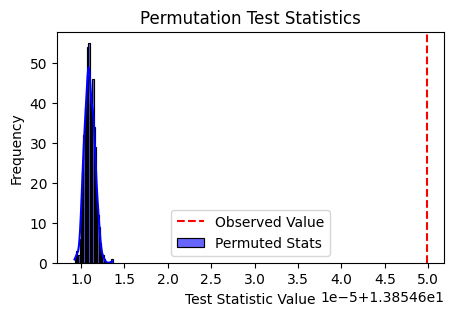

In [1]:
import numpy as np
import os
os.chdir(os.path.dirname(os.getcwd()))
from src.twosample.ker import KernelTwoSampleTest  # or wherever your factory is defined

# Instantiate the KLR test class
KLR0 = KernelTwoSampleTest('KLR-0')

# Generate synthetic samples
np.random.seed(0)
sample_size = 100
dimension = 500
X = np.random.multivariate_normal(np.zeros(dimension), np.eye(dimension), sample_size)
Y = np.random.multivariate_normal(np.ones(dimension),  np.eye(dimension), sample_size)

# Initialize test 
test = KLR0(X, Y, 
           band_factor_ls=[0.1, 0.5, 1], 
           ridge_ls=[1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1],
           kernel_name='sqeuclidean',
           symmetrise=True, project=True)

# Run the test with permutation-based calibration; 500 random permutations, and 8 cores for parallel processing, significance level of 0.05
result = test(num_permutations=500, level=0.05, NUM_CORES=8) 
print(f"P-Value: {result.p_value:.4f}")
print(f"Reject Null: {'Yes' if result.decision == 1 else 'No'}")

import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.figure(figsize=(5, 3))
sns.histplot(result.permuted_stats, kde=True, bins=30, color='blue', alpha=0.6, label='Permuted Stats') # Plot KDE and histogram of permuted statistics
plt.axvline(result.obs_value, color='red', linestyle='--', label=f'Observed Value') # Add vertical line for observed test statistic
plt.title('Permutation Test Statistics'); plt.xlabel('Test Statistic Value'); plt.ylabel('Frequency'); plt.legend(); plt.show()